# Funciones útiles para la parte de ML

In [1]:
# Common imports y set up de cada notebook

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import time

# Para mantener los resultados constantes al ejecutar
np.random.seed(42) # Un random.seed constante

# Para graficar figuras bonitas
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)



# Guardar/importar imágenes

PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Guardar/importar datos
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, "data")
os.makedirs(DATA_PATH, exist_ok=True)

## 1. Convertir la serie temporal en un problema de ML

In [2]:
# Esta función transforma la serie en un problema de machine learning


def serie_to_ML(serie, instancias, instante, avance = 1):
    
    # Serie es un np.darray
    # La función devuelve los arrays X e Y
    # X = [samples, instancias]
    # Y = [samples, instante] --> para multi step forecasting
    
    # instancias es el nº de instantes previos conocidos (embedding dimension, d)
    # instante es cuánto queremos ver en el futuro (event horizon, p)
    # avance es un parámetro que controla la separación entre instancias del set. P.e: avance = 4*24, separación de
    #                                                                                                 un día      
    X, Y = list(), list()
    Y = list()

    for i in range(0,len(serie)+1, avance):
        final_id_x = i + instancias
        final_id_y = final_id_x + instante
        if final_id_y > len(serie)-1:
            break
        slice_x, slice_y = serie[i:final_id_x], serie[final_id_x:final_id_y] 
        X.append(slice_x)
        Y.append(slice_y)
    
    return np.array(X),np.array(Y)

## 2. Medidas de error

In [3]:
# R^2. 

# El coeficiente de determinación. Muestra el "parecido" entre dos series
# Resultado: (-inf,1]. 1 == perfecto

from sklearn.metrics import r2_score  


##########################################################################################

# MSE

# Resultado [0,inf)

from sklearn.metrics import mean_squared_error


##########################################################################################


# RMSE 

# Resultado [0,inf)

from sklearn.metrics import mean_squared_error

def RMSE(Y, Y_predicted):
    
    return np.sqrt(mean_squared_error(Y, Y_predicted))


##########################################################################################


# MAPE

# Lo mismo que el MAE pero en forma de porcentaje. Resultado [0,inf)

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


## 3. Modelos de base naive 

In [4]:
def baseline_model_1(sample, previous_sample=1): # cualquier instante anterior
    
    # Sample es una sola muestra
    # previous_sample es la muestra anterior que queremos que se devuelva
    # útil cuando queremos predecir el instante t + n
    
    if previous_sample > len(sample):
        return ("No hay instantes anteriores a t-"+str(sample))
    forecast = sample[-previous_sample]
    return forecast

# Función auxiliar:

def return_forecast_baseline_model_1(series,previous_sample=1):
    
    # series es un conjunto de samples
    
    forecasts = np.ndarray(len(series))
    for i in range(len(series)):     
        sample = series[i]
        prediction = baseline_model_1(sample,previous_sample)
        forecasts[i] = prediction
    return forecasts


#################################################################################################


def baseline_model_2(sample, previous_week, previous_day, previous_time = True): 
    
    # sample es una sola muestra de cualquier longitud
    # previous_time, previous_day, previous_week son los 
    # instantes anterior, del día anterior y de la semna anterior, cuya media queremos calcular
    
    if previous_time == False:   
        average = (sample[-previous_day] + sample[-previous_week])/2
        return average
    
    average = (sample[-1] + sample[-previous_day] + sample[-previous_week])/3
    return average

# Función auxiliar:
def return_forecast_baseline_model_2(series, previous_week, previous_day, previous_time):
    
    # series es un conjunto de samples
    
    forecasts = np.ndarray(len(series))
    for i in range(len(series)):     
        sample = series[i]
        prediction = baseline_model_2(sample,previous_week, previous_day, previous_time)
        forecasts[i] = prediction
    return forecasts

## 4. Graficar datos

In [1]:
# Función para graficar series temporales:

def plot__real_vs_predicted(Y_real, Y_predicted, x_limits = (0,-1), y_limits = (29158,77853), savefig = False, figname = "figure", formato = "png"):
    
    
    name = figname + "." + formato
    
    plt.figure(figsize = (12.8,7.2))
    
    plt.ylim(y_limits)
    
    plt.plot(Y_real[x_limits[0]:x_limits[-1]], color = "black", linestyle = "-", linewidth=2, label="Real"), # color = "darkorange",
    plt.plot(Y_predicted[x_limits[0]:x_limits[-1]], "r-.", linewidth=2, label="Predicted")
    plt.legend(loc = 1, fontsize=17)   
    plt.xlabel("Time (15 min)", fontsize=14) 
    plt.ylabel("Comsumption", fontsize=14)      
    plt.grid(which='major', axis='both', color='grey', linestyle='--', linewidth=0.75)
    
    if savefig == True:
        plt.tight_layout()
        plt.savefig(os.path.join(IMAGES_PATH, name), 
                    format = formato, dpi = 200)
    
    plt.show() 
    
    
    
###################################################################################################################
    

def plot_train_vs_val(train_errors, val_errors, x_limits = (0,-1), y_limits = (-100000,100000), savefig = False, 
                            figname = "figure", formato = "png"):
        
    name = figname + "." + formato
    
    plt.figure(figsize = (12.8,7.2))
    
    plt.ylim(y_limits)
    
    plt.plot(train_errors[x_limits[0]:x_limits[-1]], "b-.", linewidth=2, label="Train"), # color = "darkorange",
    plt.plot(val_errors[x_limits[0]:x_limits[-1]], "r-.", linewidth=2, label="Val")
    plt.legend(loc = 1, fontsize=17)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14)      
    plt.grid(which='major', axis='both', color='grey', linestyle='--', linewidth=0.75)
    
    if savefig == True:
        plt.tight_layout()
        plt.savefig(os.path.join(IMAGES_PATH, name), 
                    format = formato, dpi = 200)
    
    plt.show()

## 5. Guardar un modelo de ML

In [6]:
#from joblib import dump, load

#dump(rfr, 'rfr.joblib') # guardado del modelo
#rfr = load('rfr.joblib') # importar modelo

# Otra manera de guardar modelos de machine learning

#import pickle
#save_rfr = pickle.dumps(rfr)
#rfr_loaded = pickle.loads(save_rfr)

## 6. Entrenamiento y learning curves de time series

In [7]:
def ts_one_split_training(model, X, Y, val_size = 0.3, savefig = False, figid = 1, formato = "png"):
    
    
    # Esta función ENTRENA un modelo de ML y muestra sus Learning curves.
        
    train_errors, val_errors = [], []
    
    size = Y.size
    
    X_train, Y_train = X[:int(size*(1-val_size))], Y[:int(size*(1-val_size))]
    X_val, Y_val = X[int(size*(1-val_size)):], Y[int(size*(1-val_size)):]
    print(X.shape, Y.shape, X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, )
    start_time = time.time()
    
    iteraciones = Y_train.size

    for i in range(iteraciones):
        
        index = i+1    
        if (index + 1) > iteraciones:
            break
            
        X_train_slice, Y_train_slice = X[:index], Y[:index]
        
        model.fit(X_train_slice, Y_train_slice)
            
        Y_train_slice_predicted = model.predict(X_train_slice)
        Y_val_predicted = model.predict(X_val)
        
        train_errors.append(RMSE(Y_train_slice, Y_train_slice_predicted))
        val_errors.append(RMSE(Y_val, Y_val_predicted))
        
        current_time = time.time()
    
        if i%10 == 0: # Notificación para ver cuánto tiempo de entrenamiento lleva, y cuánto queda.
            print("training: "+str(i)+" of "+str(iteraciones), "current time: "+str(current_time - start_time) + " s")

    execution_time = time.time() - start_time
    
# Graficar los datos    
    
    plt.figure(figsize = (12.8,7.2))
    plt.plot(train_errors, "b-.", linewidth=2, label="train")                  
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown
    
    if savefig == True:
        plt.tight_layout()
        plt.savefig(os.path.join(IMAGES_PATH, "train"+str(figid)+"."+formato), 
                    format = formato, dpi = 200)
    
    plt.show()
    
    plt.figure(figsize = (12.8,7.2))
    plt.plot(val_errors, "r-.", linewidth=2, label="Validation")                  
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown
    
    if savefig == True:
        plt.tight_layout()
        plt.savefig(os.path.join(IMAGES_PATH, "val"+str(figid)+"."+formato), 
                    format = formato, dpi = 200)
    
    plt.show()
        
    print("tiempo de ejecución: "+str(execution_time)+" s")
    return train_errors, val_errors

## 7. Predicción recurrente

In [40]:
def recurrent_prediction(model, X_sample, predictions):
    
    # predictions es cuántos instantes queremos predecir en el futuro
    
    aux1 = np.copy(X_sample) # un array de ceros con la forma de X_sample
    aux2 = np.zeros_like(X_sample)
    broadcast = []
    
    for i in range(predictions):
    
        prediction = model.predict(aux1)
        broadcast.append(prediction)
        
        aux2[:,0:-1] = aux1[:,1:]    
        aux2[:,-1] = prediction
        
        aux1 = np.copy(aux2)
        
    return broadcast

# Ejemplo de comienzo de proyecto

In [9]:
training_set = pd.read_csv(os.path.join(DATA_PATH, "germany_train_data.csv"))
serie = np.array(training_set["load"])
X, Y = serie_to_ML(serie, 672, 1, avance = 1) # Lo convierto en un problema de machine learning
Y = Y.flatten()
X.shape, Y.shape

((148367, 672), (148367,))

In [15]:
from sklearn.linear_model import LinearRegression

In [17]:
lr1 = LinearRegression(n_jobs = -1)

(2144, 672) (2144,) (1500, 672) (1500,) (644, 672) (644,)
training: 0 of 1500 current time: 0.32884955406188965 s
training: 10 of 1500 current time: 0.3628568649291992 s
training: 20 of 1500 current time: 0.4469318389892578 s
training: 30 of 1500 current time: 0.5335614681243896 s
training: 40 of 1500 current time: 0.6402513980865479 s
training: 50 of 1500 current time: 0.7681586742401123 s
training: 60 of 1500 current time: 0.926328182220459 s
training: 70 of 1500 current time: 1.127753496170044 s
training: 80 of 1500 current time: 1.3791260719299316 s
training: 90 of 1500 current time: 1.6537940502166748 s
training: 100 of 1500 current time: 1.979661464691162 s
training: 110 of 1500 current time: 2.3657336235046387 s
training: 120 of 1500 current time: 2.8115057945251465 s
training: 130 of 1500 current time: 3.3047068119049072 s
training: 140 of 1500 current time: 3.8085927963256836 s
training: 150 of 1500 current time: 4.3803839683532715 s
training: 160 of 1500 current time: 5.01797

training: 1440 of 1500 current time: 359.6489486694336 s
training: 1450 of 1500 current time: 363.68765902519226 s
training: 1460 of 1500 current time: 367.9524302482605 s
training: 1470 of 1500 current time: 372.21023654937744 s
training: 1480 of 1500 current time: 376.3963978290558 s
training: 1490 of 1500 current time: 380.6572892665863 s


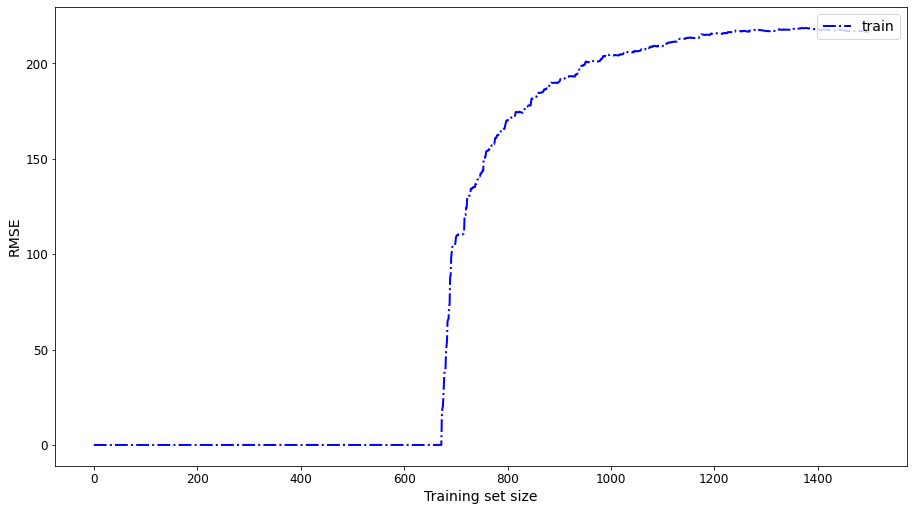

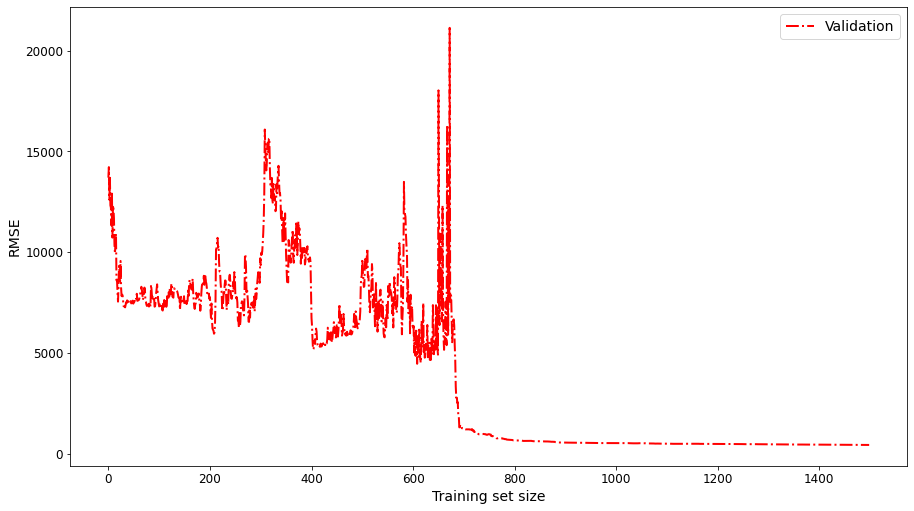

tiempo de ejecución: 383.78057050704956 s


In [18]:
X_slice = X[:2144]
Y_slice = Y[:2144]


train_errors, val_errors = ts_one_split_training(lr1, X_slice, Y_slice, val_size = 0.3,
                                                 savefig = True, figid = 1, formato = "png")

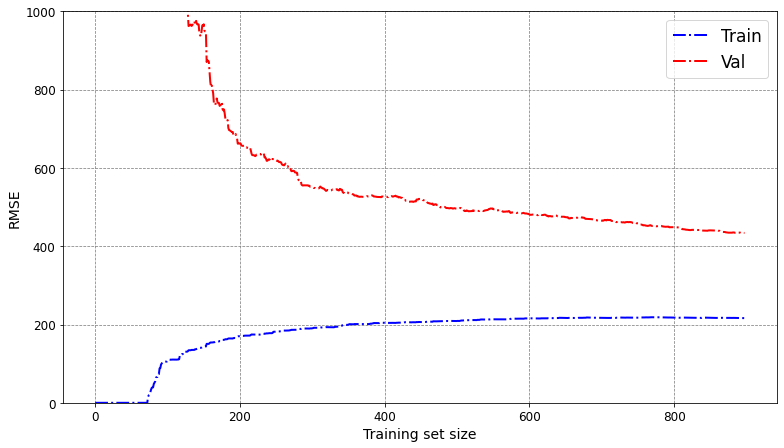

In [25]:
plot__train_vs_val(train_errors, val_errors, x_limits = (600,-1), y_limits = (0,1000), savefig = False, 
                            figname = "figure", formato = "png")

317.88179353448584
734.022686482992


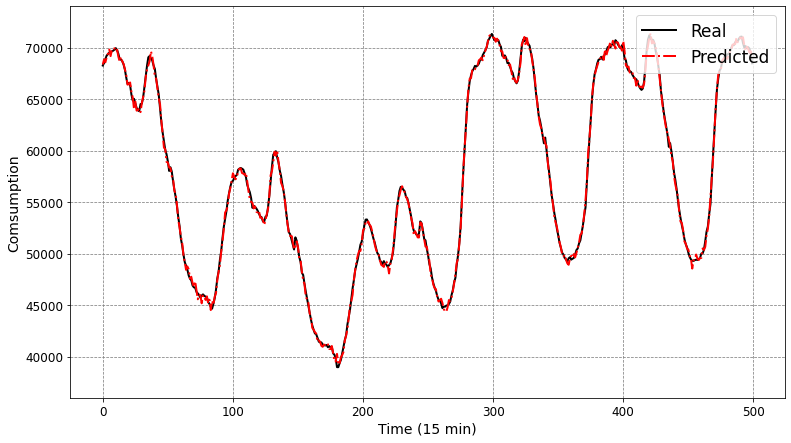

In [26]:
Y_real = Y[2144:5000]
X_real = X[2144:5000]
Y_predicted = lr1.predict(X_real)

print(RMSE(Y_real, Y_predicted))
print(RMSE(Y_real, return_forecast_baseline_model_1(X_real, previous_sample=1)))


      
plot__real_vs_predicted(Y_real, Y_predicted, x_limits = (0,500), y_limits = (36000,74000), savefig = False, figname = "figure", formato = "png")
    

In [51]:
def recurrent_prediction(model, X_sample, predictions):
    
    # predictions es cuántos instantes queremos predecir en el futuro
    
    aux1 = np.copy(X_sample) # un array de ceros con la forma de X_sample
    aux2 = np.zeros_like(X_sample)
    broadcast = []
    
    for i in range(predictions):
    
        prediction = model.predict(aux1)
        broadcast.append(prediction)
        
        aux2[:,0:-1] = aux1[:,1:]    
        aux2[:,-1] = prediction
        
        aux1 = np.copy(aux2)
        
    return np.array(broadcast).flatten()


Y_recurrent = np.array(recurrent_prediction(lr1, X[4000].reshape(1,4*24*7), 500))
Y_recurrent.shape, Y[4000:4500].shape


((500,), (500,))

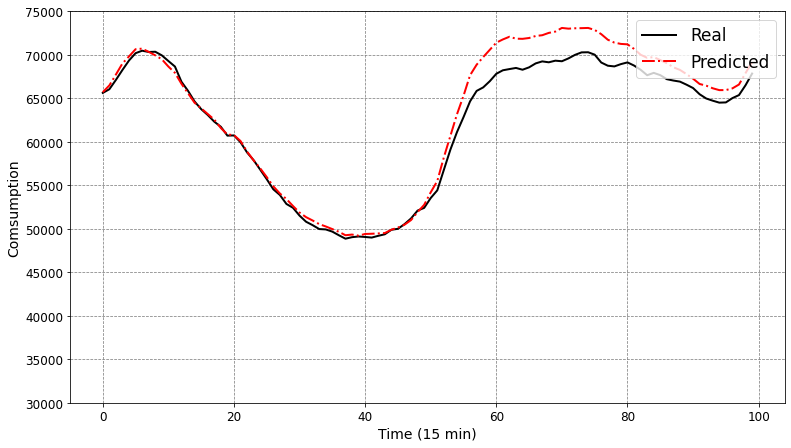

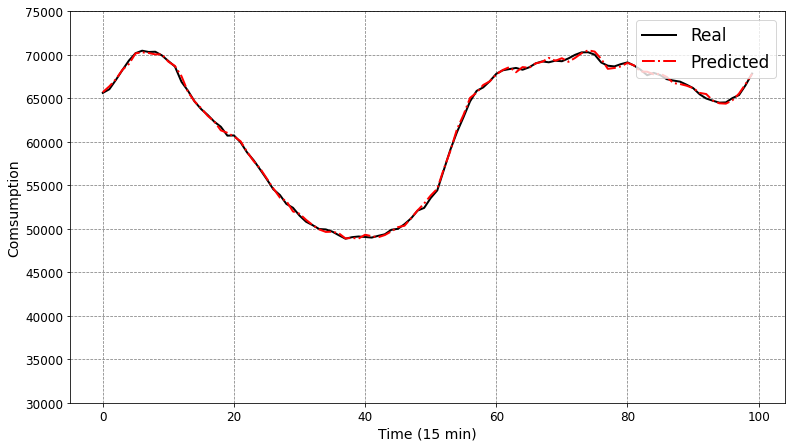

348.5635822294465
218.53556015700516


In [58]:
plot__real_vs_predicted(Y[4000:4500], Y_recurrent, x_limits = (0,100), y_limits = (30000,75000), savefig = False, figname = "figure", formato = "png")
plot__real_vs_predicted(Y[4000:4500], lr1.predict(X[4000:4500]), x_limits = (0,100), y_limits = (30000,75000), savefig = False, figname = "figure", formato = "png")


print(RMSE(Y[4000:4050], Y_recurrent[:50])) 
print(RMSE(Y[4000:4050], lr1.predict(X[4000:4050])))